# Example of a Hierarchical Dirichet Process Mixture Model for Topic Modeling

In [1]:
using BNP

## Generate test data

In [2]:
# define size of bar image
img_size = 5

# define amount of noise
noise_level = 0.01

# define probabilities of generating a particular number of bars
num_per_mixture = [0 ones(1,3)] ./ 3

# define number of groups (J)
num_group = 40

# define number of data items drawn from each group
num_data = 50;

In [3]:
# generate data
(samples, bars) = generateBarsDataset(img_size, noise_level, num_per_mixture, num_group, num_data);

## visualize data

Interact.Slider{Int64}([Reactive.Input{Int64}] 20,"group",20,1:40)

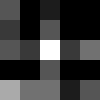

In [5]:
using Images
using Interact

# create array of sample images used for training
I = Array{Array}(num_group)

# loop over groups / documents
for i in 1:num_group
    
    II = zeros(img_size, img_size)
    
    for j in samples[i]
        xi, yi = ind2sub(size(II), j)
        
        II[xi, yi] += 1
    end
    
    # assign document
    I[i] = II ./ maximum(II)
end

# Interactivelly visualize data
@manipulate for group in 1:num_group
    grayim(I[group])
end

## visualize topics

Interact.Slider{Int64}([Reactive.Input{Int64}] 5,"topic",5,1:10)

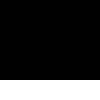

In [6]:
# create array of shared distributions (topics) underlying the data
I = Array{Array}(num_group)

# loop over all shared distributions
for i in 1:size(bars, 2)
    
    II = reshape(bars[:,i], img_size, img_size)
    
    # assign shared distributions image
    I[i] = II ./ maximum(II)
end

# Interactivelly visualize shared distributions
@manipulate for topic in 1:size(bars, 2)
    grayim(I[topic])
end

# train HDP using collapsed Gibbs sampling

In [8]:
# Dimensionality of the data
D = img_size * img_size

# We assume a Multinomial Distribution with a Dirichlet Prior as base distribution
H = MultinomialDirichlet(D, 1.0)

# Train a Hierarical Dirichlet Process Mixture Model guessing 10 shared Distributions
models = train(BNP.HDP(H, α = 1.0), Gibbs(), RandomInitialisation(k = 10), samples);

# visualize infered topics

Interact.Slider{Int64}([Reactive.Input{Int64}] 50,"iteration",50,1:100)

Interact.Slider{Int64}([Reactive.Input{Int64}] 5,"topic",5,1:10)

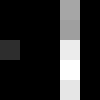

In [41]:
# create an array to store the resulting topics for each iteration
R = Array{Array}(length(models))

# loop over all iterations
for iter in 1:length(models)

    # filter out empty distributions (topics)
    G = filter(x -> x.n > 0, models[iter].G)

    # create array of resulting topics for this iteration
    I = Array{Array}(length(G))

    # loop over all topics
    for i in 1:length(G)

        # reshape distribution to 2d image dimensions
        II = reshape(full(G[i].counts), img_size, img_size)

        # assign and normalize (necessary for visualisation)
        I[i] = II ./ maximum(II)
    end
    
    # assign to results array
    R[iter] = I
end

@manipulate for iteration in 1:length(models), topic in 1:size(bars, 2)
    grayim(R[iteration][topic])
end